# Setup

In [1]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from experiments.irl.fair_irl import *
from research.irl.fair_irl import *
from research.utils import *


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

# Run experiments

In [2]:
base_exp_info = {
    'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
    # Expert demo parameters
    'DATASET': None,
    'TARGET_DATASET': None,
    'N_EXPERT_DEMOS': 3,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 25_000,
    # IRL Loop parameters
    'N_TRIALS': 6,
    'IRL_METHOD': None,
    'N_INIT_POLICIES': 1,
    'EPSILON': .03,
    'MAX_ITER': 6,
    'METHOD': 'highs',
    # Plotting parameters
    'NOISE_FACTOR': .02,
    'ANNOTATE': True,
}

In [3]:
experiments = [
    {
        'DATASET': 'COMPAS',
        'TARGET_DATASET': 'Adult',
        'EXPERT_ALGO': 'HardtDemPar',
        'IRL_METHOD': 'FairIRL',
        'N_TRIALS': 3,
    },
]

In [4]:
for exp_i, experiment in enumerate(experiments):
    logging.info('\n\n')
    logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
    exp_info = dict(base_exp_info)
    
    for k in experiment:
        exp_info[k] = experiment[k]
        
    run_experiment(exp_info)

INFO:root:


INFO:root:EXPERIMENT 1/1
INFO:root:exp_info: {'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'COMPAS', 'TARGET_DATASET': 'Adult', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtDemPar', 'N_DATASET_SAMPLES': 25000, 'N_TRIALS': 3, 'IRL_METHOD': 'FairIRL', 'N_INIT_POLICIES': 1, 'EPSILON': 0.03, 'MAX_ITER': 6, 'METHOD': 'highs', 'NOISE_FACTOR': 0.02, 'ANNOTATE': True}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.60137162 0.96817096 0.98568111]
 [0.60094299 0.99426785 0.94171421]
 [0.59391081 0.99678211 0.99917066]]
INFO:root:muE_hold:
[[0.59211654 0.97894149 0.96450205]
 [0.59811482 0.98444708 0.97208951]
 [0.60034305 0.9807162  0.93712693]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:Best Learned Policy yhat: 0.334
INFO:root:best weight:	 [0.701 0.192 0.107]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.601,0.968,0.986,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
1,0.601,0.994,0.942,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
2,0.594,0.997,0.999,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
3,0.509,0.997,0.998,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.000,0.000
4,0.630,0.713,0.717,0,0.630,0.626,0.626,0.713,0.732,0.732,0.717,0.715,0.715,0.0,1.0,0.978,-0.003,0.019,0.378,0.349,0.378,0.349
5,0.597,0.964,0.993,0,0.597,0.595,0.595,0.964,0.969,0.969,0.993,0.993,0.993,0.0,2.0,0.701,0.192,0.107,0.029,0.037,0.029,0.037


INFO:root:muE_target:
[[0.76199616 0.97239529 0.9656932 ]
 [0.7618819  0.98497291 0.98156089]
 [0.76284205 0.9903242  0.84001735]]
INFO:root:target domain muL = [0.755 0.973 0.939]
INFO:root:target domain muE = [0.762 0.983 0.929]
INFO:root:target domain muL_hold = [0.766 0.971 0.883]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.60265752 0.99643044 0.96918907]
 [0.62066009 0.99060399 0.97857889]
 [0.59519726 0.98899014 0.98353489]]
INFO:root:muE_hold:
[[0.6066838  0.97036138 0.98807471]
 [0.58526135 0.99273262 0.93789054]
 [0.58404803 0.9821283  0.983528  ]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:	IRL Loop iteration 3/6 ...
INFO:root:	IRL Loop iteration 4/6 ...
INFO:root:	IRL Loop iteration 5/6 ...
INFO:root:	IRL Loop iteration 6/6 ...
INFO:root:Best Learned Policy yhat: 0.386
INFO:root:best weight:	 [0.254 0.313 0.433]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.603,0.996,0.969,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
1,0.621,0.991,0.979,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
2,0.595,0.989,0.984,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
3,0.491,0.937,0.957,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.000,0.000
4,0.589,0.957,0.885,0,0.589,0.609,0.609,0.957,0.974,0.974,0.885,0.874,0.874,0.0,1.0,0.571,0.284,0.145,0.100,0.098,0.100,0.098
5,0.591,0.954,0.886,0,0.591,0.608,0.608,0.954,0.968,0.968,0.886,0.867,0.867,0.0,2.0,0.262,0.300,0.438,0.100,0.098,0.100,0.098
6,0.591,0.954,0.886,0,0.591,0.608,0.608,0.954,0.968,0.968,0.886,0.867,0.867,0.0,3.0,0.254,0.313,0.433,0.100,0.098,0.100,0.098
7,0.591,0.954,0.886,0,0.591,0.608,0.608,0.954,0.968,0.968,0.886,0.867,0.867,0.0,4.0,0.254,0.313,0.433,0.100,0.098,0.100,0.098
8,0.591,0.954,0.886,0,0.591,0.608,0.608,0.954,0.968,0.968,0.886,0.867,0.867,0.0,5.0,0.254,0.313,0.433,0.100,0.098,0.100,0.098
9,0.589,0.992,0.936,0,0.589,0.606,0.606,0.992,1.000,1.000,0.936,0.915,0.915,0.0,6.0,0.254,0.313,0.433,0.045,0.059,0.045,0.059


INFO:root:muE_target:
[[0.79222649 0.97696592 0.99184281]
 [0.7618819  0.96822865 0.94866071]
 [0.78540566 0.98769452 0.91765601]]
INFO:root:target domain muL = [0.761 0.978 0.944]
INFO:root:target domain muE = [0.78  0.978 0.953]
INFO:root:target domain muL_hold = [0.76  0.983 0.929]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.5932276  0.99132583 0.95472398]
 [0.59065581 0.9774601  0.90924783]
 [0.59133791 0.9852552  0.9836623 ]]
INFO:root:muE_hold:
[[0.6101114  0.99350726 0.97909147]
 [0.6075407  0.99456223 0.99190445]
 [0.60034305 0.98296501 0.95494734]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:	IRL Loop iteration 3/6 ...
INFO:root:	IRL Loop iteration 4/6 ...
INFO:root:	IRL Loop iteration 5/6 ...
INFO:root:	IRL Loop iteration 6/6 ...
INFO:root:Best Learned Policy yhat: 0.520
INFO:root:best weight:	 [ 0.915 -0.084  0.   ]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.593,0.991,0.955,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
1,0.591,0.977,0.909,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
2,0.591,0.985,0.984,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.000,0.000
3,0.515,0.991,0.972,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.000,0.000
4,0.629,0.656,0.667,0,0.629,0.616,0.616,0.656,0.642,0.642,0.667,0.657,0.657,0.0,1.0,0.915,-0.084,0.000,0.435,0.472,0.435,0.472
5,0.628,0.645,0.652,0,0.629,0.617,0.616,0.656,0.629,0.642,0.667,0.646,0.657,0.0,2.0,0.699,0.267,-0.034,0.435,0.472,0.435,0.472
6,0.628,0.645,0.652,0,0.629,0.617,0.616,0.656,0.629,0.642,0.667,0.646,0.657,0.0,3.0,0.698,0.268,-0.035,0.435,0.472,0.435,0.472
7,0.628,0.645,0.652,0,0.629,0.617,0.616,0.656,0.629,0.642,0.667,0.646,0.657,0.0,4.0,0.698,0.268,-0.034,0.435,0.472,0.435,0.472
8,0.628,0.645,0.652,0,0.629,0.617,0.616,0.656,0.629,0.642,0.667,0.646,0.657,0.0,5.0,0.698,0.267,-0.034,0.435,0.472,0.435,0.472
9,0.628,0.645,0.652,0,0.629,0.617,0.616,0.656,0.629,0.642,0.667,0.646,0.657,0.0,6.0,0.698,0.267,-0.035,0.435,0.472,0.435,0.472


INFO:root:muE_target:
[[0.77159309 0.99903259 0.97373737]
 [0.77964474 0.98747484 0.93371517]
 [0.77916467 0.98901767 0.92014247]]
INFO:root:target domain muL = [0.785 0.872 0.812]
INFO:root:target domain muE = [0.777 0.992 0.943]
INFO:root:target domain muL_hold = [0.79  0.876 0.794]


# Compare results with source domain only

In [5]:
!rm ../../data/experiment_output/fair_irl/exp_info/.DS_Store
!rm ../../data/experiment_output/fair_irl/exp_results/.DS_Store

rm: ../../data/experiment_output/fair_irl/exp_info/.DS_Store: No such file or directory
rm: ../../data/experiment_output/fair_irl/exp_results/.DS_Store: No such file or directory


DATASET: Boston


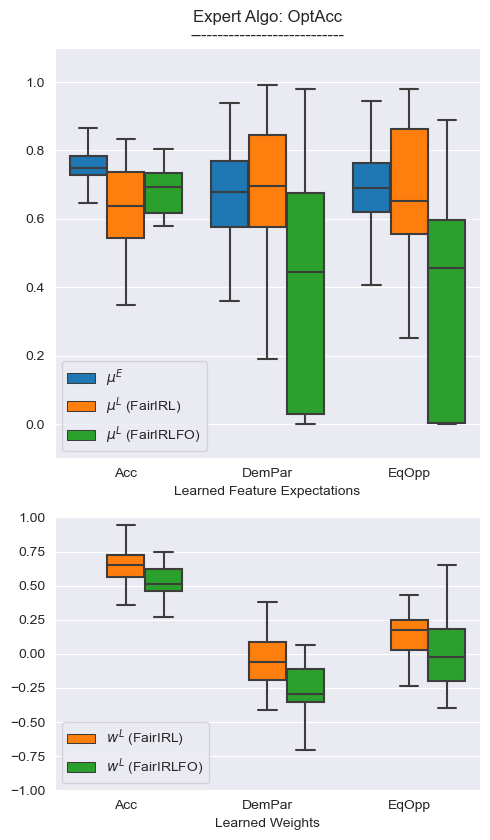

In [6]:
n_expert_demos = 3
n_init_pols = 1

mu_df, w_df = plot_results_source_domain_only(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='OptAcc',
    dataset='Boston',
    mu_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=(lambda info: (info['N_EXPERT_DEMOS'] != n_expert_demos) or (info['N_INIT_POLICIES'] != n_init_pols)),
#     extra_title=f"Expert Demos: {n_expert_demos}"
)

DATASET: Boston


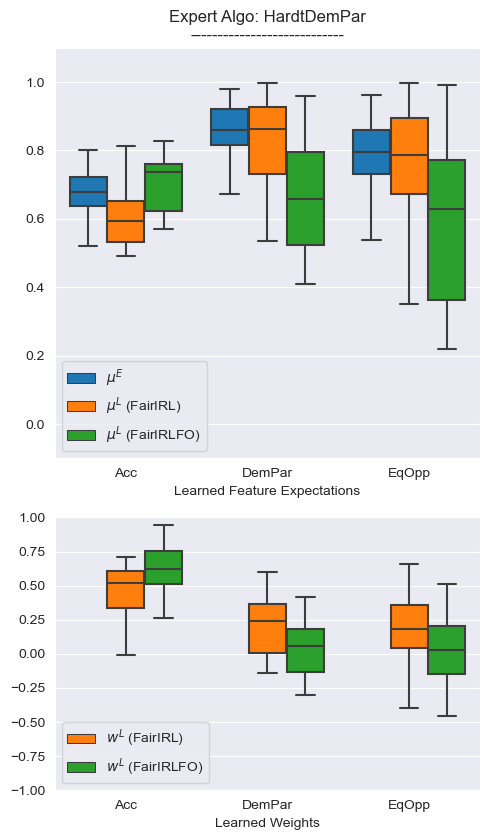

In [7]:
n_expert_demos = 3
n_init_pols = 1

mu_df, w_df = plot_results_source_domain_only(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtDemPar',
    dataset='Boston',
    mu_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=(lambda info: (info['N_EXPERT_DEMOS'] != n_expert_demos) or (info['N_INIT_POLICIES'] != n_init_pols)),
#     extra_title=f"Expert Demos: {n_expert_demos}"
)

DATASET: Boston


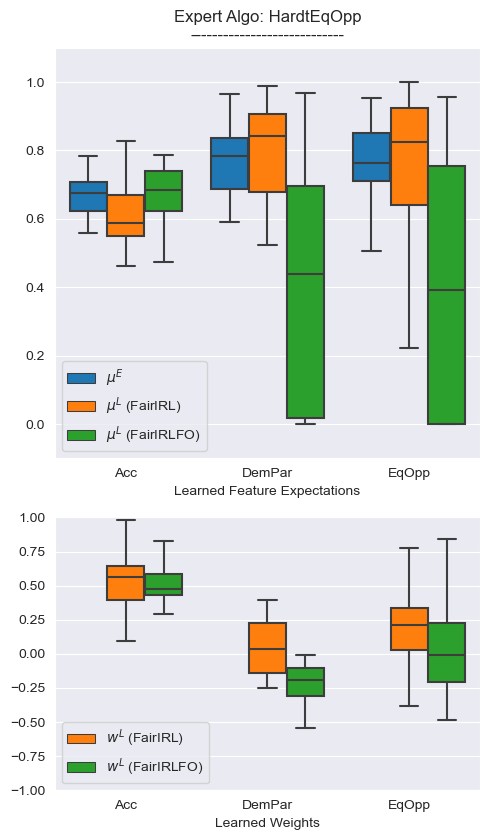

In [8]:
n_expert_demos = 3
n_init_pols = 1

mu_df, w_df = plot_results_source_domain_only(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtEqOpp',
    dataset='Boston',
    mu_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=(lambda info: (info['N_EXPERT_DEMOS'] != n_expert_demos) or (info['N_INIT_POLICIES'] != n_init_pols)),
#     extra_title=f"Expert Demos: {n_expert_demos}"
)

# Compare results with target domain

SOURCE DATASET: Boston
TARGET DATASET: COMPAS


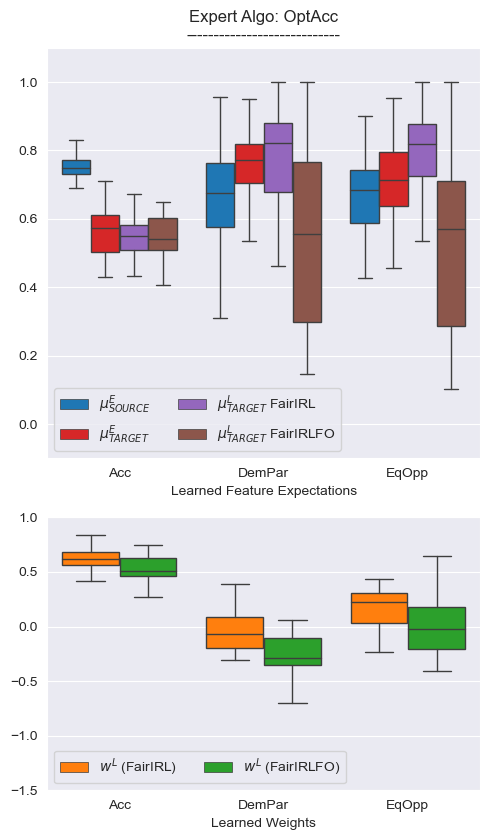

In [20]:
mu_df, w_df = plot_results_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='OptAcc',
    source_dataset='Boston',
    target_dataset='COMPAS',
    mu_noise_factor=.1,
    w_noise_factor=.01,
)

SOURCE DATASET: Boston
TARGET DATASET: COMPAS


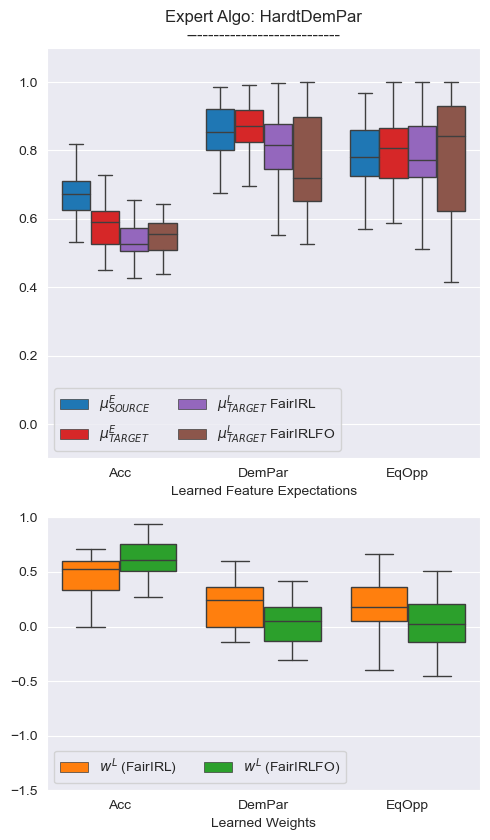

In [21]:
mu_df, w_df = plot_results_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtDemPar',
    source_dataset='Boston',
    target_dataset='COMPAS',
    mu_noise_factor=.1,
    w_noise_factor=.01,
)

SOURCE DATASET: Boston
TARGET DATASET: COMPAS


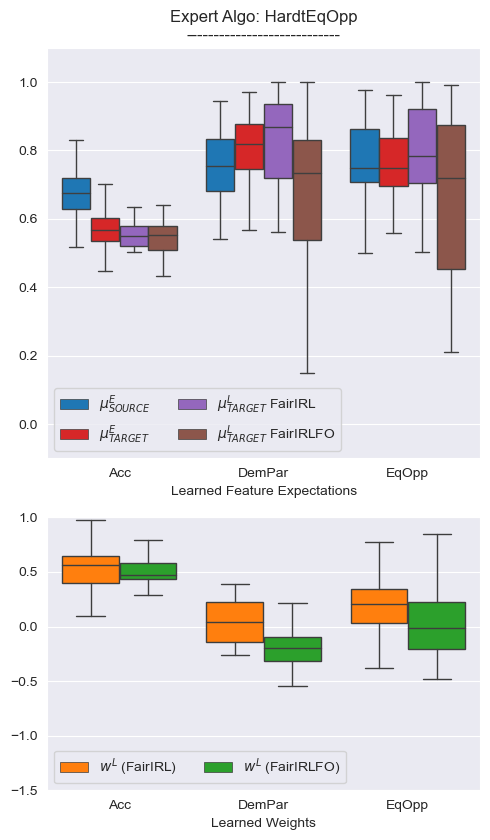

In [22]:
mu_df, w_df = plot_results_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtEqOpp',
    source_dataset='Boston',
    target_dataset='COMPAS',
    mu_noise_factor=.1,
    w_noise_factor=.01,
)

# Scratch